# Calibrating the Liquid Drop Model Challenge

The purpose of this challenge is for you to calibrate the Liquid Drop Model https://en.wikipedia.org/wiki/Semi-empirical_mass_formula and compare the results of a "black box" calibration vs a principled Bayesian one.

Your task is to:

- Import the data from the AME 2016 table (included in the github). We are only using nuclei above A=16 to avoid light nuclei where the LDM fails particularly. Perform a curve fit using the built in functions from python (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) and take note of the reported uncertainties in the parameters. 
- Make a plot of the residuals and estimate the model error on its best fit. 
- Make a model calibration using the Bayesian formalism that is defined in the acompaning file "# Guided Example Bayesian calibration". For the error, use your estimation from the previous point (the model error in this case is much smaller than the actual experimental uncertainties). 
- Plot the corner plot posterior as well as the model values on the Binding Energy per nucleon for the Calcium chain up to 60Ca including the available experimental data.
- What would be the results if you have used in the calibration the Binding Energy per nucleon instead of the total Binding Energy?
- Bonus: Find the experimental error in the masses and repeat the calibration using only experimental errors. This should give a good demonstration on the dangers of not taking into account model errors. 

In [2]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import corner

In [3]:
data = np.loadtxt('Masses2016.txt', skiprows=1)

def LDM(x, a,b,c,d):
    #x = (n,z)
    #params= parameters (volume, surface, asymmetry, Coulomb)
    # a,b,c,d = params
    n=x[0]
    z=x[1]
    
    return a*(n+z) - b*(n+z)**(2/3) - c*((n-z)**2/(n+z)) - d*((z**2)/((n+z)**(1/3)))

[10.43922687 14.17286414  5.35349066  0.48936185]
[1.93534318e-03 1.87158300e-02 1.18554875e-02 9.39627473e-06]


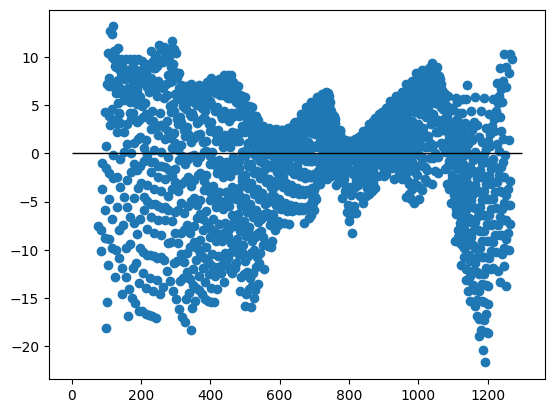

In [4]:
Z = data[:,1]; N = data[:,0]; Mlist = data[:,2]

p0 = (10,14,5,0.5)

Mcompare = [] # initial guess
index = np.zeros(len(Mlist), dtype = int)
Nnew = [] ; Znew = []
for i in range(len(Mlist)):
    if N[i] + Z[i] > 20:
      Mcompare.append(Mlist[i])
      Nnew.append(N[i])
      Znew.append(Z[i])

Nheavy = np.array(Nnew) ; Zheavy = np.array(Znew)
X = (Nheavy,Zheavy)

param, pcov = curve_fit(LDM,X, Mcompare , p0)
perr = np.diag(pcov)
print(param)
print(perr)

# residuals

diff = np.zeros(len(Mcompare))
for i in range(len(Mcompare)):
    diff[i] = Mcompare[i] - LDM(X, *param)[i]


plt.figure()
plt.scatter(Mcompare, diff)
plt.hlines(0, xmin = 0, xmax = 1300, color = 'black', linewidth = 1)

# Now Try the Bayesian Approach with emcee

In [5]:
from scipy.optimize import minimize
# finding maximum likelihood parameters

# Determine errors from model fit from before

HighP = param + perr ; lowP = param - perr

Highend = LDM(X,*HighP) ; Lowend = LDM(X, *lowP)

Modelerr = abs((Highend-Lowend))

def log_likelihood(theta, n,z,mass, sigma):
    a,b,c,d, log_f = theta
    model = a*(n+z) - b*(n+z)**(2/3) - c*((n-z)**2/(n+z)) - d*((z**2)/((n+z)**(1/3)))
    sigma2 = sigma**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((mass - model) ** 2 / sigma2 + np.log(sigma2))

X = (Nheavy,Zheavy,Mcompare)
# np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)

initial = np.array([*param,0.1]) + 0.1 * np.random.randn(5)

soln = minimize(nll, initial, args=(X[0],X[1],X[2], Modelerr))

a_ml, b_ml, c_ml, d_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("a = {0:.3f}".format(a_ml))
print("b = {0:.3f}".format(b_ml))
print("c = {0:.3f}".format(c_ml))
print("d = {0:.3f}".format(d_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

# plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
# plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
# plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
# plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
# plt.legend(fontsize=14)
# plt.xlim(0, 10)
# plt.xlabel("x")
# plt.ylabel("y");

Maximum likelihood estimates:
a = 10.368
b = 13.933
c = 3.231
d = 0.497
f = 0.016


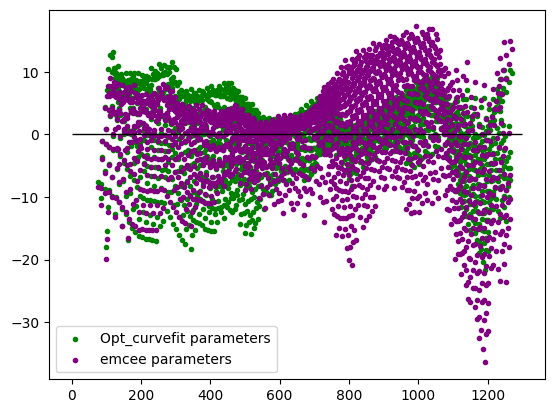

In [6]:
diff1 = np.zeros(len(Mcompare)); diff2 = np.zeros(len(Mcompare))
for i in range(len(Mcompare)):
    diff1[i] = Mcompare[i] - LDM(X,*param)[i]
    diff2[i] = Mcompare[i] - LDM(X, a_ml, b_ml, c_ml, d_ml)[i]


plt.figure()
plt.scatter(Mcompare, diff1, color = 'green', marker = '.', label = 'Opt_curvefit parameters')
plt.scatter(Mcompare, diff2, color = 'purple', marker = '.', label = 'emcee parameters')
plt.legend(loc = 'best')

plt.hlines(0, xmin = 0, xmax = 1300, color = 'black', linewidth = 1)

Setting up prior

In [7]:
def log_prior(theta):
    a,b,c,d, log_f = theta
    if 0.0 < a < 12 and 2.0 < b < 15.0 and -3 < c < 7 and -2 < d < 2 and -5 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_probability(theta, n,z,mass, sigma):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, n,z,mass, sigma)


In [9]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 5)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(Nheavy,Zheavy,Mcompare, Modelerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:43<00:00, 114.46it/s]


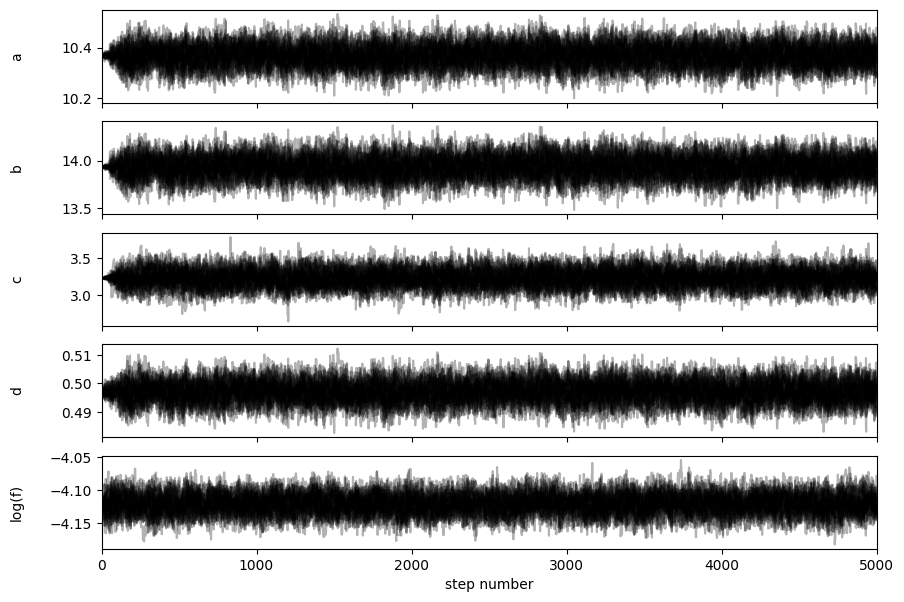

In [10]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "c", "d", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [11]:
tau = sampler.get_autocorr_time()
print(tau)

[53.91872813 53.72644367 53.88997342 54.30204445 54.34661655]


In [12]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 5)


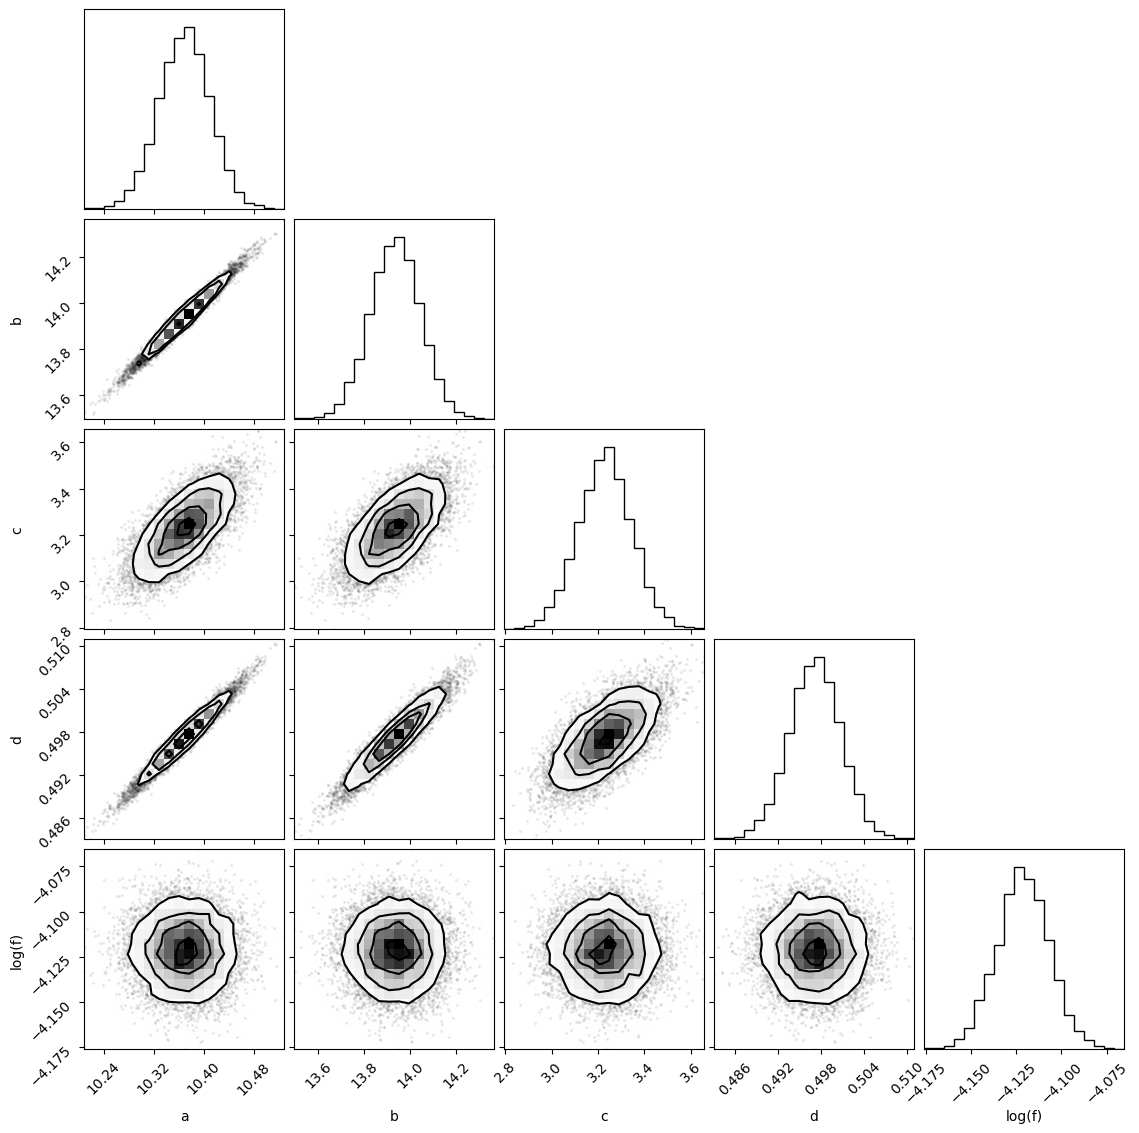

In [13]:
import corner
# f_true = 0.01
# a,b,c,d = param
fig = corner.corner(
    flat_samples, labels=labels
);

In [14]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>